# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: Bowen Xu
*   Your **student number**:1006411786



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

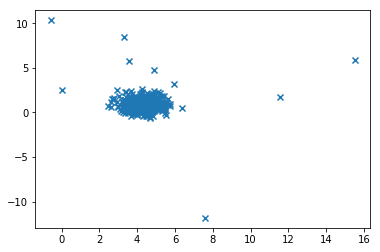

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");


Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = X.sum(axis=0)
    mu = sum_/m
    
    # compute variance of X
    var = sum((X-mu)**2)/m
    
    return mu,var
mu, sigma = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

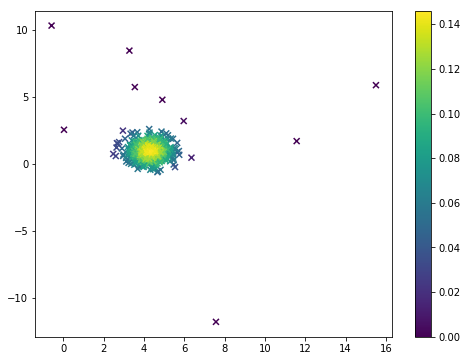

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.015

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

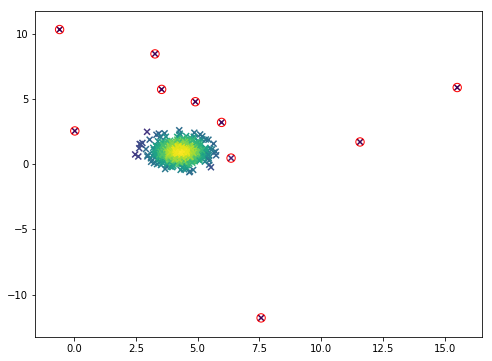

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the lowest value of K for which we get precision of 1.0? __**10**__
* What is the precision for K=4? _**1.0**___

In [7]:
from sklearn.metrics import precision_score
precision_1=[]
for i in range(0,15):
     mn = sorted(p)[i]
     sc = precision_score( y_true,1*(p<=mn))
     if sc==1.0:
      precision_1.append(i+1)
     if i+1 == 4:
      print('When K is',4,',the precision is', sc)
print('When the precision is 1.0, the maximum value of K is',max(precision_1))

When K is 4 ,the precision is 1.0
When the precision is 1.0, the maximum value of K is 10


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

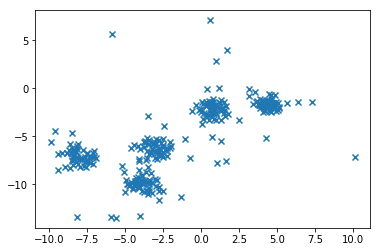

In [8]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? _**1.0**__
* k=10? _**0.9**__
* k=100? _**0.13**__

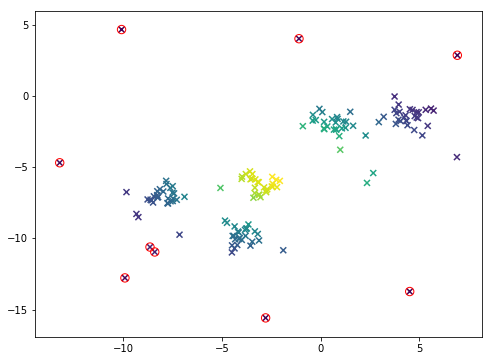

In [9]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70); 

In [10]:
#my code here
from sklearn.metrics import precision_score
for i in range(len(p)):
     mn = sorted(p)[i]
     sc = precision_score( y_test,1*(p<=mn))
     if i+1 == 1:
      print('K is ',i+1, ', precision is', sc)
     elif i+1 == 10:
        print('K is ',i+1, ', precision is', sc)
     elif i+1 == 100:
        print('When K is',i+1, ', precision is', sc)

K is  1 , precision is 1.0
K is  10 , precision is 0.9
When K is 100 , precision is 0.13


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [11]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

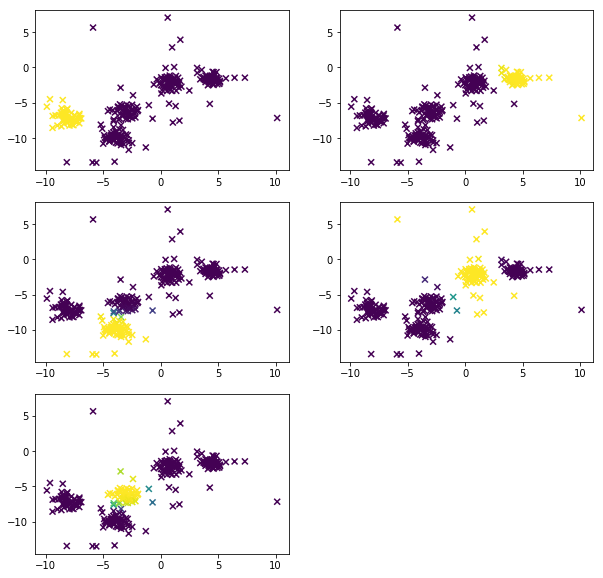

In [12]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.

* Is this model better or worse performing than the previous?     

**When K=1, the precision is 1; when K=10, the precision is 1; when K=100, the precision is 0.18 which are better than the previous one**

* Why might that be? 

**Previous one was using multivariate gaussians which is the joint distribution of at least two variables, it takes as parameters a vector of means for each variable and a variance-covariance matrix, containing the variance of each single variable and the covariances between pairs of variables.
A Gaussian mixture model is quite diffrent since it is actually the distribution of a single variable that, instead of being drawn from a single Gaussian-distributed population, is assumed to arise from a mixture of different Gaussian components, each one with a specific probability, with these probabilities summing up to one.** 

**Therefore, gaussian mixture model is better and more accurate than multivariate gaussians for finding outliers because mixture of probability of individual gaussian is always more accurate than getting means by combining all gaussians toghther**

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


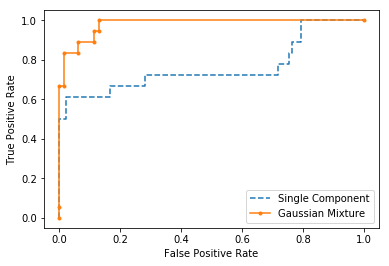

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

Although our MoG model doesn't perfectly identify all the outliers, it performs way better than our previous model, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [14]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-10-23 01:22:20--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-10-23 01:22:20--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0.003s  

2019-10-23 01:22:20 (7.30 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? 

**The modal rating is 7.1**
* What is the range of ratings?

**The range of rating s for all Simpsons episodes is 4.0---9.3**

The modal rating is 7.1
The range of ratings is 4.0 --- 9.3


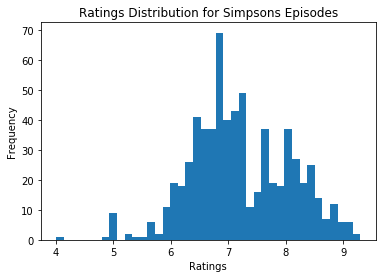

In [15]:
from statistics import mode
episodes, ratings = [], []
for key, value in sorted(simpsons.items()):
  for k,v in value.items():
        episodes.append(k)
        ratings.append(v)
plt.hist(ratings,bins = 40)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Distribution for Simpsons Episodes')
print('The modal rating is',mode(ratings))
print('The range of ratings is',min(ratings),'---',max(ratings))

Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? 

**The means are 6.786 and 8.204 for bad and good ratings, respectively**
* What about the standard deviations? 

**The standard deviations are 0.6022 and 0.4579 for bad and good ratings, respectively**

In [16]:
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
rating_train = np.array(ratings).reshape(-1,1)
gm.fit(rating_train)
print('The two gaussians have two means of',gm.means_,'respectively')
print('The standard deviations of two gaussians are',np.sqrt(gm.covariances_),'respectively')

The two gaussians have two means of [[6.7734211 ]
 [8.17942889]] respectively
The standard deviations of two gaussians are [[[0.59689303]]

 [[0.4741226 ]]] respectively


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point?

**According to the graph, the notable drop-off point starts from Season 8**
* When is the first season with 0 good episodes?

**The first season with 0 good episodes is Season 15**

The first season with 0 good episodes is Season 15


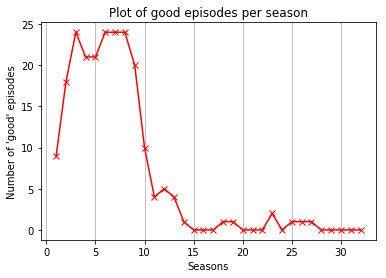

In [17]:
#predict the ratings as good or bad
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
y_pred = gm.predict(rating_train)

#get the number of episodes epi per season
epi = []
for key, value in sorted(simpsons.items()):
    epi.append(len(value.keys()))
epi.append(0) # add a zero at the end for future convenience
epi_sea = np.array(epi)

#extract certain number of predictions based on epi and count the good ones
index1,index2 = 0,epi_sea[0]
number,zero = [],[]
for i in range(1,len(epi_sea)):
  pred = y_pred[index1:index2]
  number.append((pred==1).sum())
  y = np.array(number)
  if number[i-1] == 0:
    zero.append(i)
  index1 += epi_sea[i-1]
  index2 += epi_sea[i]
# print('Season',i,'has',number[i-1],'\'good\' episodes')

print('The first season with 0 good episodes is Season',zero[0])

# plot the graph
x = np.arange(1,len(epi_sea))
plt.plot(x,y,marker='x',color='r')
plt.xlabel('Seasons')
plt.ylabel('Number of \'good\' episodes')
plt.title('Plot of good episodes per season')
plt.xticks()
plt.grid(axis='x')
plt.show()

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] 

**There are 284807 rows in total**
* What features in the dataset are present aside from the 28 main features?[1] 

**Columns with names 'Time', 'Amount' and 'Class'**
* Why do you think the main features are given to us in this way?[1]

**Due to confidentiality issues, the author of datasets can not provide the original features and more backgroud information about the data. Therefore, the oringinal data is transformed to V1-V28 features by Principle Component Analysis**
* Which column contains the targets? Can you figure out what the values correspond to?[1] 

**column 'Class' contains targets '1' and '0' which means the sample is either a fraud or a non-fraud, respectively**

In [18]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=84e8a509aa7facaee4be516a44dd6002fb344678185b06543fbe5bdcfbd190c4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [19]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [20]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

#my code here
df = pd.read_csv('creditcard.csv')
print('There are',len(df),'rows in this dataset')
print('This datasets include classes',set(df['Class']))
df.head()

There are 284807 rows in this dataset
This datasets include classes {0, 1}


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1]

**99.8273% of data is in class "0"(non-fraud), 0.1727% of data is in class "1"(fraud)**
* Why might this pose a problem with methods we have looked at so far?[1]

**The entire dataset is highly unbalanced which will cause a bias to the prediction model towards the more common class**



In [23]:
print(round(len(df[df['Class'] == 0])/len(df)*100,4),'% of the dataset is classifies as 0 class')
print(round(len(df[df['Class'] == 1])/len(df)*100,4),'% of the dataset is classifies as 1 class')

99.8273 % of the dataset is classifies as 0 class
0.1727 % of the dataset is classifies as 1 class


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] 

**The mean is 0.000921 and the standard deviation is 0.605592 for the column "V24"**

Use the code below to set up a Gaussian object for V24.

In [24]:
from sklearn.model_selection import train_test_split
X = df.drop('Class',axis = 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,random_state=0,stratify=y)
mean_24 = X_train['V24'].mean()
std_24 = X_train.loc[:,"V24"].std()
print('The mean for variable V24 is',mean_24)
print('The standard deviation for variable V24 is',std_24)

The mean for variable V24 is 0.0009206126117002949
The standard deviation for variable V24 is 0.6055920069331981


In [0]:
from scipy import stats

norm = stats.norm(loc=mean_24,scale=std_24)

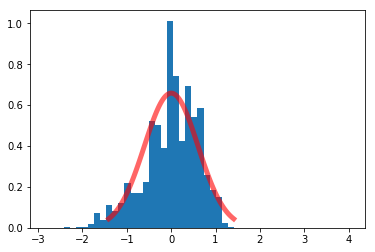

In [26]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

**Findings and Best Model:**

**For this question, there will be three situations need to be taken into considerations: 1.for same set of features, changing the number of component in the GaussianMixture model; 2.for same number of component in the model, changing the sets of different features; 3.for both same set of features and number of component, changing k values. Both precision scores and recall scores are recorded in the tables shown below and the relationships between the variables are shown in the graphs.**

**1. For same set of features, changing the number of component in the GaussianMixture model. By looking at two graphs, we can see the precision scores for each k value are almost constant with a slight decrease as n increases from 2 to 6, similarly, the recall scores are also decreasing by a small extent as n increases. Furthermore, by looking at the trend of the graph, we can see that the precision scores are decreasing as k values getting larger, recall scores are increasing.(this will be further proved by the last graph)**

**2. For same number of component in the model, changing the sets of different features. The features are chosen intentionally based on the diversity or information given from each column, sets ['V21','V22','V23','V24','V25'] and ['V1','V2','V3','V4','V5'] have small variances(two peaks(means) for fraud and non-fraud are really closed to each other), sets ['V11','V12','V13','V14','V15'] and ['V11','V12','V13','V15','V17'] have high have high variances(two peaks(means) for fraud and non-fraud are separate away from each other). By looking at the graphs,we can see clearly that the precision and recall scores for feature set 1 and 2 are really low and feature set 3 and 4 have obvious improvement on both scores. Therefore, we can conclude that features with high variances are more informative and precise than those with low variances**

**3. For both same set of features and number of component, changing k values. For this part, I chose the most informative feature set from last part which is ['V11','V12','V13','V15','V17'] to get better results. We can clearly see the trends for for both precision and recall scores: as k value is increasing, the precision is decreasing but recall is increasing. We could say  the intersection point of two curves is the optimum point which is at k ≈ 160.The reasons behind this is: the precision defines the percentage of outliers are correctly selected at a specific classification threshold, and recall means the percentage of true outliers over all outliers in the dataset. Therefore, as k value increases, i.e. more points will be selected, more true outliers will be selected from the dataset, then recall will increase as more true outliers are found out. However, larger k values will also make more wrong predictions (predict as outlier, but not outlier,i.e.false positives)on the outliers which will cause the precision getting smaller and smaller**

**By combining all three situations, the best model could be n=2(best from 1), using feature set ['V11','V12','V13','V15','V17'] (best from 2), and k =160 (best from 3).**

In [0]:
#This part using same set of features but different n-component values, the precision
#and recall scores are calculated based on five different k values for each number of component

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd

X_test1 = X_test[features]
pre_list,recall_list = [],[]

for j in range(5):
  samples = X_test1[['V11','V12','V13','V15','V17']]
  gm = GaussianMixture(n_components = 2+j,covariance_type ='full', random_state=0)
  gm.fit(samples)
  p_s = gm.score_samples(samples)

  for k in [1,10,20,50,100]: 
      mn_gm = sorted(p_s)[k] 
      precision = precision_score(y_test, p_s < mn_gm) 
      pre_list.append(precision)
      recall = recall_score(y_test, p_s < mn_gm) 
      recall_list.append(recall)

Set number of component n as variable:


The precision table is:
 Different n-component         2     3     4         5     6
K values                                                   
1                      1.000000  1.00  1.00  0.000000  0.00
10                     1.000000  1.00  0.90  0.900000  0.90
20                     0.842105  0.80  0.80  0.789474  0.80
50                     0.800000  0.78  0.78  0.780000  0.74
100                    0.710000  0.73  0.71  0.660000  0.65


The recall table is:
 Different n-component         2         3         4         5         6
K values                                                               
1                      0.006098  0.006098  0.006098  0.000000  0.000000
10                     0.060976  0.060976  0.054878  0.054878  0.054878
20                     0.097561  0.097561  0.097561  0.091463  0.097561
50                     0.243902  0.237805  0.237805  0.237805  0.225610
100                    0.432927  0.445122  0.432927  0.402

Text(0.5, 1.0, 'Recall vs. K-values for Different Number of n-component')

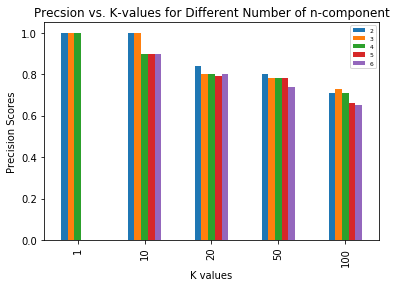

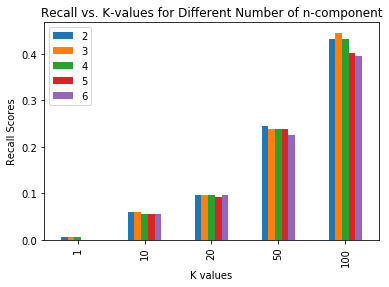

In [0]:
#print precision and recall scores by changing  number of n-components 

arrays1 = ['1','10','20','50','100']
pre_array = np.array(pre_list).reshape(-1,5).T
recall_array = np.array(recall_list).reshape(-1,5).T
df_pre = pd.DataFrame(pre_array,index=arrays1,columns=range(2,7))
df_pre.columns.name='Different n-component'
df_pre.index.name='K values'

df_recall = pd.DataFrame(recall_array,index=arrays1,columns=range(2,7))
df_recall.columns.name='Different n-component'
df_recall.index.name='K values'
print('Set number of component n as variable:\n\n')
print('The precision table is:\n',df_pre)
print('\n')
print('The recall table is:\n',df_recall,'\n')

df_pre.plot.bar()
plt.legend(loc='upper right', prop={'size': 6})
plt.ylabel('Precision Scores')
plt.title('Precsion vs. K-values for Different Number of n-component')
df_recall.plot.bar()
plt.legend(loc='best')
plt.ylabel('Recall Scores')
plt.title('Recall vs. K-values for Different Number of n-component')

In [0]:
#This part using same number of component n=4 but four different sets of features, the precision
#and recall scores are calculated based on five different k values for each set of fetures

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

X_test1 = X_test[features]
pre_list1,recall_list1 = [],[]

fea = np.array([['V21','V22','V23','V24','V25'],['V1','V2','V3','V4','V5'],
                ['V11','V12','V13','V14','V15'],['V11','V12','V13','V15','V17']])

for j in range(len(fea)):
  samples = X_test1[fea[j]]
  gm = GaussianMixture(n_components = 4,covariance_type ='full', random_state=0)
  gm.fit(samples)
  p_s = gm.score_samples(samples)

  for k in [1, 10, 20, 50, 100]: 
      mn_gm = sorted(p_s)[k] 
      precision = precision_score(y_test, p_s < mn_gm) 
      pre_list1.append(precision)
      recall = recall_score(y_test, p_s < mn_gm) 
      recall_list1.append(recall)

Set different features as variable:


The precision table is:
 Different features     1     2     3     4
K values                                  
1                   0.00  0.00  1.00  1.00
10                  0.00  0.00  0.90  0.90
20                  0.00  0.20  0.80  0.80
50                  0.02  0.26  0.76  0.78
100                 0.01  0.21  0.70  0.71


The recall table is:
 Different Features         1         2         3         4
K values                                                  
1                   0.000000  0.000000  0.006098  0.006098
10                  0.000000  0.000000  0.054878  0.054878
20                  0.000000  0.024390  0.097561  0.097561
50                  0.006098  0.079268  0.231707  0.237805
100                 0.006098  0.128049  0.426829  0.432927 



Text(0.5, 1.0, 'Recall vs. K-values for Different Features')

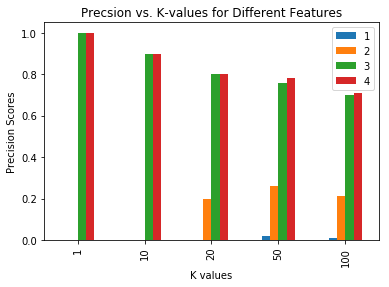

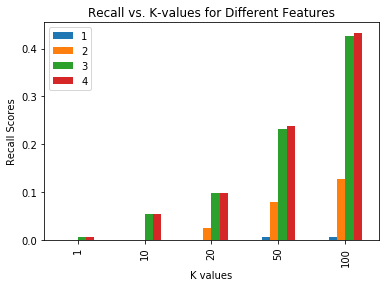

In [0]:
#print precision and recall scores by changing  different sets of features

arrays3 = ['1','10','20','50','100']
pre_array1 = np.array(pre_list1).reshape(-1,5).T
recall_array1 = np.array(recall_list1).reshape(-1,5).T
df_pre1 = pd.DataFrame(pre_array1,index=arrays3,columns=range(1,5))
df_pre1.columns.name='Different features'
df_pre1.index.name='K values'

df_recall1 = pd.DataFrame(recall_array1,index=arrays3,columns=range(1,5))
df_recall1.index.name='K values'
df_recall1.columns.name='Different Features'
print('Set different features as variable:\n\n')
print('The precision table is:\n',df_pre1)
print('\n')
print('The recall table is:\n',df_recall1,'\n')

df_pre1.plot.bar()
plt.legend(loc='upper right')
plt.ylabel('Precision Scores')
plt.title('Precsion vs. K-values for Different Features')
df_recall1.plot.bar()
plt.legend(loc='best')
plt.ylabel('Recall Scores')
plt.title('Recall vs. K-values for Different Features')

In [0]:
#This part using same number of component n=5 ans same set of features ['V11','V12','V13','V15','V17'], 
#the precision and recall scores are calculated based on 300 cotinuous k values

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

X_test1 = X_test[features]
pre_list2,recall_list2 = [],[]

fea = np.array([['V11','V12','V13','V15','V17']])

samples = X_test1[fea[0]]
gm = GaussianMixture(n_components = 5,covariance_type ='full', random_state=0)
gm.fit(samples)
p_s = gm.score_samples(samples)

for k in range(300): 
  mn_gm = sorted(p_s)[k] 
  precision = precision_score(y_test, p_s < mn_gm) 
  pre_list2.append(precision)
  recall = recall_score(y_test, p_s < mn_gm) 
  recall_list2.append(recall)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


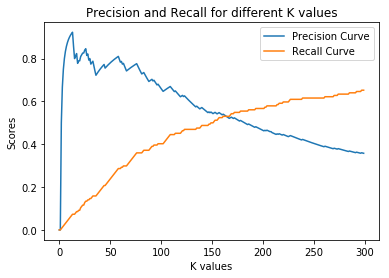

In [0]:
#print precision and recall scores by changing k values

pr = plt.plot(range(300),pre_list2,label='Precision Curve')
plt.plot(range(300),recall_list2,label='Recall Curve')
plt.xlabel('K values')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.title('Precision and Recall for different K values')
plt.show()